# GAN networks with semantic maps in the input 
## Training and results visualisation

In [1]:
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import time
import datetime
import os
import numpy as np
import tensorflow as tf
from IPython import display
from importlib import reload
import model_fcts as mod
import preprocessing_fcts as pp
import loss_fcts as loss

import seg_models

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
OUTPUT_CHANNELS = 1
BATCH_SIZE = 1
EPOCHS = 40
TRAIN_LENGTH = 8708

### Retrieve network generating the semantic maps (restore checkpoint)

In [3]:
name = 'seg_model'
inputs = tf.keras.layers.Input(shape=[512,512, 4])
net = seg_models.PixUnet(inputs, relu=True, activ='sigmoid')
segmentor = mod.Generator(inputs=inputs, outputs=net)
checkpoint = tf.train.Checkpoint(model=segmentor)
checkpoint.restore('training_checkpoints/seg/' + name + '/ckpt-1')

### Generate the semantic maps

In [4]:
raw_train_dataset, raw_test_dataset = pp.load_tf_ds(512)
train_dataset, test_dataset = pp.normalize_tf_dataset(raw_train_dataset, True), pp.normalize_tf_dataset(raw_test_dataset, True)

In [5]:
train_masks = segmentor.predict(train_dataset.batch(BATCH_SIZE))
test_masks = segmentor.predict(test_dataset.batch(BATCH_SIZE))

256/256 [==============================] - 10s 37ms/step


### Make the dataset to train and test the GAN networks
#### --> Convert the 512x512 pixels semantic maps to 4x256x256 pixels (to be adapted to the GAN input) 

In [6]:
def divide_tensor(image):
    return tf.convert_to_tensor([image[0:256,0:256], image[0:256,256:512], image[256:512,0:256], image[256:512,256:512]])

def divide_one_array(image):
    return np.array([image[0:256,0:256], image[0:256,256:512], image[256:512,0:256], image[256:512,256:512]])

def mask_ds_gen(mod):
    if mod == 0:
        for mask in train_masks256:
            yield mask
    if mod == 1:
        for mask in test_masks256:
            yield mask
    if mod == 2:
        for mask in val_masks256:
            yield mask

divide_array = np.vectorize(divide_one_array)

In [8]:
train_masks = (train_masks>=0.5).astype('int32') # threshold to set all the values of the semantic map to 0 or 1
train_masks256 = np.array(list(map(divide_one_array,train_masks))).reshape(8708,256,256,1) # split each mask in 4 to be compatible with 256x256 pixels DSMs
train_masks_ds = tf.data.Dataset.from_generator(mask_ds_gen, args=(0,), output_signature=(tf.TensorSpec(shape=(256,256,1), dtype=tf.float32))) #from np array to tf dataset

#separate input and DTM

train_input = raw_train_dataset.map(lambda x,y:tf.reshape(x[:,:,0], [512,512,1]))
train_dtm = raw_train_dataset.map(lambda x,y:y)

#split input and DTM to format 256x256

train_input = train_input.map(lambda x: divide_tensor(x))
train_dtm = train_dtm.map(lambda x: divide_tensor(x))

train_input = train_input.flat_map(tf.data.Dataset.from_tensor_slices)
train_dtm = train_dtm.flat_map(tf.data.Dataset.from_tensor_slices)

#put masks and DSMs together

raw_train_dataset256 = tf.data.Dataset.zip((train_input,train_dtm)).map(lambda x,y: (x, tf.reshape(y,[256,256])))
train_dataset256 = pp.normalize_tf_dataset(raw_train_dataset256, False)

train_dataset256 = tf.data.Dataset.zip((train_dataset256, train_masks_ds))
train_dataset256 = train_dataset256.map(lambda x,y: (tf.concat((x[0],y),axis=-1), x[1]))


In [9]:
test_masks = (test_masks>=0.5).astype('int32')
test_masks256 = np.array(list(map(divide_one_array,test_masks))).reshape(1024,256,256,1)
test_masks_ds = tf.data.Dataset.from_generator(mask_ds_gen, args=(1,), output_signature=(tf.TensorSpec(shape=(256,256,1), dtype=tf.float32)))

test_input = raw_test_dataset.map(lambda x,y:tf.reshape(x[:,:,0], [512,512,1]))

test_dtm = raw_test_dataset.map(lambda x,y:y)
    
test_input = test_input.map(lambda x: divide_tensor(x))
test_dtm = test_dtm.map(lambda x: divide_tensor(x))

test_input = test_input.flat_map(tf.data.Dataset.from_tensor_slices)
test_dtm = test_dtm.flat_map(tf.data.Dataset.from_tensor_slices)

raw_test_dataset256 = tf.data.Dataset.zip((test_input,test_dtm)).map(lambda x,y: (x, tf.reshape(y,[256,256])))
test_dataset256 = pp.normalize_tf_dataset(raw_test_dataset256, False)

test_dataset256 = tf.data.Dataset.zip((test_dataset256, test_masks_ds))
test_dataset256 = test_dataset256.map(lambda x,y: (tf.concat((x[0],y),axis=-1), x[1]))

### Version of test_RMSE and test_L1 (already defined in model_fcts) adapted to the datasets used here

In [10]:
@tf.autograph.experimental.do_not_convert
def test_RMSE(preds): 
    """
    Computes the RMSE of a set of predictions
    """
    tbs = [] #list containing the value of highest and lowest pixel in each DSM (for normalization)
    res = preds[0].shape[1] #256 or 512
    test_ds = raw_test_dataset256
    tbs_ds = test_ds.map(lambda x, y : (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0])))
    
    for i in tbs_ds.as_numpy_iterator(): #fill the tbs list
        tbs.append(i)
    
    dtms = test_ds.map(lambda x, y: y)
    ssum = 0
    n = res**2

    N = str(preds.shape[0])
    i = 0
    for j in dtms.as_numpy_iterator():
        pred = preds[i]
        pred = pp.denormalize(pred, tbs[i][0], tbs[i][1])
        dif = np.sum((pred[:,:,0] - j)**2)
        ssum += dif
        i += 1
        #print(str(i) + '/' + N, end='\r')
    #print(i)
    print('i : ' + str(i))
    print('n : ' + str(n))
    return np.sqrt(ssum/(i*n))

@tf.autograph.experimental.do_not_convert
def test_L1(preds): 
    tbs = []
    res = preds[0].shape[1]
    test_ds = raw_test_dataset256
    tbs_ds = test_ds.map(lambda x, y : (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0])))
    
    for i in tbs_ds.as_numpy_iterator():
        tbs.append(i)
    
    dtms = test_ds.map(lambda x, y: y)
    ssum = 0
    n = res**2

    N = str(preds.shape[0])
    i = 0
    for j in dtms.as_numpy_iterator():
        pred = preds[i]
        pred = pp.denormalize(pred, tbs[i][0], tbs[i][1])
        dif = np.sum(tf.abs((pred[:,:,0] - j)))
        ssum += dif
        i += 1
        #print(str(i) + '/' + N, end='\r')
    #print(i)
    print('i : ' + str(i))
    print('n : ' + str(n))
    return ssum/(i*n)

### Training the GAN networks

In [11]:
def GAN_fit(train_ds, test_ds, steps, generator, discriminator, inp_channels, summary_writer, name, fm=False, image_freq=1000, first_step=0):
    """
    Trains a given GAN, saves tensorboard logs, a checkpoint at the epoch with the lowest RMSE computed on the test dataset, and 3 intermediate images at each epoch
    Inputs : 
    - train_ds : tensorflow dataset (x = normalized DSM (+ rgb channels of orthophoto), y=normalized DTM)
    - test_ds : same format as train_ds
    - steps : int,  number of training steps (= number of epochs * number of steps per epoch(= length of train dataset/batch size))
    - generator : model of the generator to train (tf.keras.Model or Generator class from 'model_fcts.py')
    - discriminator : model of the discriminator to train (tf.keras.Model)
    - inp channels : int, 1 (or 4 if RGB==True)
    - summary_writer : tf.summary.SummaryWriter object, to record the logs for tensorboard
    - name, it, fm : see "train_GAN" function above
    - image_freq : int, number of steps before generating an image to visualize the progress of the training
    - first_step : int, number of the step at which to start (in case of resuming the training of a GAN that was already started)
    """
    
    checkpoint_dir = 'training_checkpoints/' + name
    
    
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)
    manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
    
    min_RMSE=20
    min_RMSE_ep=0
    
    image_dir = 'intermediate_images/' + name + '/' 
    os.mkdir(image_dir)
    example_list = [(inp, tar) for (inp, tar) in test_ds.take(3)]
    example_input, example_target = example_list[0][0], example_list[0][1]
    start = time.time()
    
    image_freq = image_freq // BATCH_SIZE
    
    res = 256
    
    generator.build((res,res,inp_channels))
    discriminator.build(((res,res,inp_channels), (res,res,1)))

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate(start=first_step):
        if (step) % image_freq == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            mod.generate_images(generator, example_input, example_target, inp_channels)
            print(f"Step: {step//1000}k")
        
        train_step(generator, discriminator, input_image, target, step, summary_writer, fm)
        
    # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every epoch
        if step % (TRAIN_LENGTH) == 0 or step == (steps-1):
            im_num = 1
            for example in example_list:
                example_input2 = example[0]
                prediction = generator(example_input2, training=True)
                np.save(image_dir + str(int(step)//1000*BATCH_SIZE) + '_' + str(im_num),np.array(prediction))
                im_num += 1
                
            # Record the RMSE of the predictions on the test dataset
            # A checkpoint is saved if the RSME is the lowest yet
            preds = generator.predict(test_ds)
            rmse = test_RMSE(preds)
            if rmse < min_RMSE:
                min_RMSE = rmse
                min_RMSE_ep = step//(TRAIN_LENGTH)
                manager.save()
            with summary_writer.as_default():
                tf.summary.scalar('RMSE', rmse, step=step//(TRAIN_LENGTH))
    return min_RMSE, min_RMSE_ep  

In [12]:
@tf.function
def train_step(generator, discriminator, input_image, target, step, summary_writer, fm):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        if fm:
            gen_total_loss, gen_gan_loss, gen_l1_loss, fm_loss = loss.generator_fm_loss2(disc_generated_output, disc_real_output, gen_output, target)
            disc_loss = loss.discriminator_loss(disc_real_output[-1], disc_generated_output[-1])
        else:
            gen_total_loss, gen_gan_loss, gen_l1_loss = loss.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = loss.discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
        
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step*BATCH_SIZE//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step*BATCH_SIZE//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step*BATCH_SIZE//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step*BATCH_SIZE//1000)
        #tf.summary.scalar('gen_grad_loss', grad_loss, step=step*BATCH_SIZE//1000)
        if fm:
            tf.summary.scalar('fm_loss', fm_loss, step=step*BATCH_SIZE//1000)


    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [13]:
%tensorboard --logdir /home/student/data/logs/gan --host 0.0.0.0

#### For the example here, to go faster, let's redefine these parameters

In [14]:
EPOCHS = 1
TRAIN_LENGTH = 1001

Time taken for 1000 steps: 122.22 sec



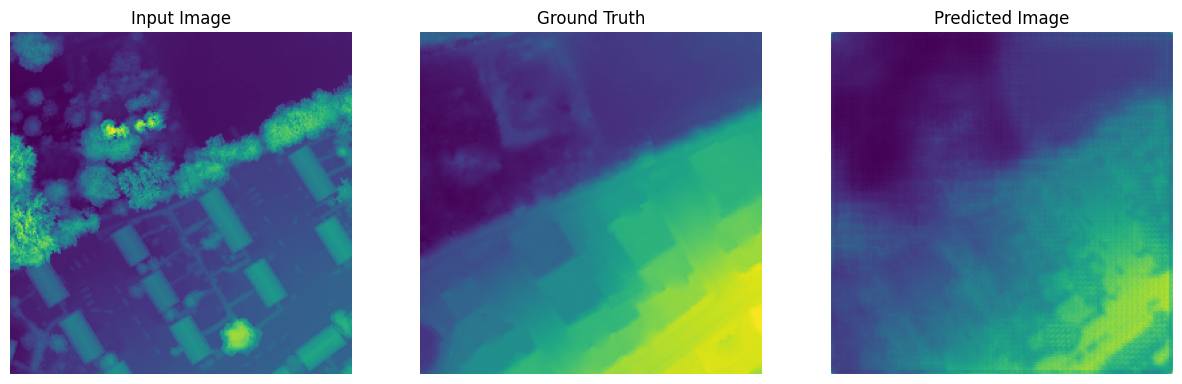

Step: 1k
1024/1024 [==============================] - 15s 14ms/step
i : 1024
n : 65536
time : 145.11768507957458 s
2.3437697716294363
tf.Tensor(0, shape=(), dtype=int64)


In [16]:
generator = mod.Generator256(2,256)
discriminator = mod.Discriminator256(2,256)
name = 'test_sem_map'
log_dir="logs/gan/"+ "fit/" + name

summary_writer = tf.summary.create_file_writer(log_dir)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

start = time.time()
print(EPOCHS*TRAIN_LENGTH)
#start training
RMSE, RMSE_ep = GAN_fit(train_dataset256.batch(BATCH_SIZE), test_dataset256.batch(BATCH_SIZE), EPOCHS*TRAIN_LENGTH, generator, discriminator, 2, summary_writer, name)
print('time : ' + str(time.time() - start) + ' s')
    
print(RMSE)
print(RMSE_ep)

# Results visualisation 

In [17]:
gen = mod.Generator256(2,256)
checkpoint = tf.train.Checkpoint(generator=gen)
checkpoint.restore('training_checkpoints/gan_sem_map/ckpt-1').expect_partial()

In [18]:
preds = gen.predict(test_dataset256.batch(BATCH_SIZE))

1024/1024 [==============================] - 15s 14ms/step


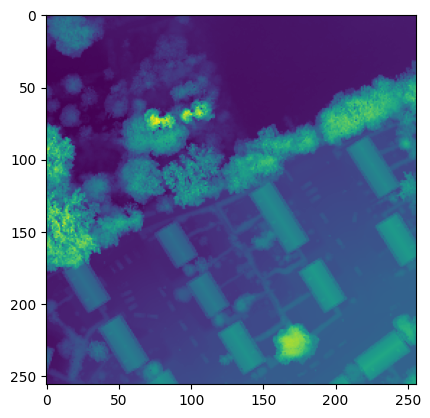

In [19]:
dsms = raw_test_dataset256.map(lambda x,y: x[:,:,0])
for i in dsms.take(1):
    plt.imshow(i)

In [22]:
tbs = [] #list containing the value of highest and lowest pixel in each DSM (for normalization)
res = preds[0].shape[1] #256 or 512
tbs_ds = raw_test_dataset256.map(lambda x, y : (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0])))
for i in tbs_ds.as_numpy_iterator(): #fill the tbs list
    tbs.append(i)

ssum = 0
ssum_L1 = 0
n = res**2
N = str(preds.shape[0])
i = 0

for j in test_ds.as_numpy_iterator():
    dtm = j[1]
    dsm = j[0][:,:,0]
    sem_map = j[0][:,:,1]
    pred = preds[i]
    pred = pp.denormalize(pred, tbs[i][0], tbs[i][1])[:,:,0]
    pred = ((sem_map-1)**2) * dsm + sem_map * pred
    dif = np.sum((pred - dtm)**2)
    dif_L1 = np.sum(tf.abs((pred - dtm)))
    ssum += dif
    ssum_L1 += dif_L1
    i += 1
    print(i, end='\r')
    
print('RMSE = ' + str(np.sqrt(ssum/(i*n))))
print('MAE = ' + str(ssum_L1/(i*n)))

RMSE = 0.9735515644824445
MAE = 0.4398475769112338


In [23]:
tf_preds = tf.data.Dataset.from_tensor_slices(preds)
tbs_ds = raw_test_dataset256.map(lambda x, y : (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0]))) #For each DSM, computes the highest and lowest point for normalization
denorm_preds = tf.data.Dataset.zip((tf_preds, tbs_ds)).map(lambda x, y: pp.denormalize(x, y[0], y[1])) # "denormalize" predicted DTMs (which have values between -1 and 1)
error_locs_ds = tf.data.Dataset.zip((denorm_preds, raw_test_dataset256)).map(lambda x, y: tf.abs(x[:,:,0] - y[1])) 
error_locs_rel = tf.data.Dataset.zip((denorm_preds, raw_test_dataset256)).map(lambda x, y: x[:,:,0] - y[1])

Text(0.5, 1.0, 'Average error of the generated DTMs \n at each pixel location')

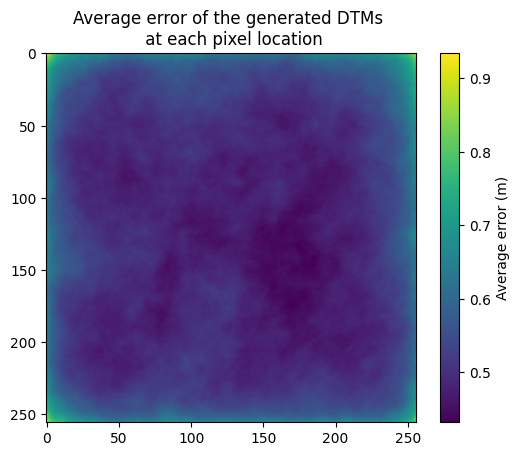

In [24]:
error_locs = error_locs_ds.reduce(np.float32(0), lambda x, y : x + y) #compute average error at every pixel coordinate
plt.imshow(error_locs/1024)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Average error (m)')
plt.title('Average error of the generated DTMs \n at each pixel location')
#plt.savefig('error_loc_sem_map.png')

Text(0.5, 1.0, 'Average value of the predicted DTMs at each pixel coordinate \n (generator trained with modified loss function)')

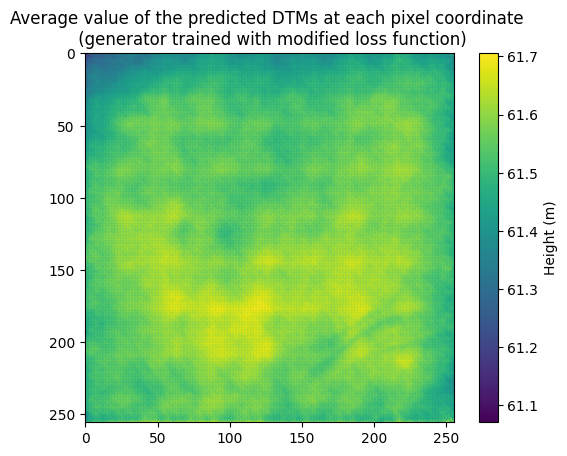

In [25]:
av_dp = denorm_preds.reduce(np.float32(0), lambda x, y : x + y)/1024
plt.imshow(av_dp)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Height (m)')
#plt.axis('off')
plt.title('Average value of the predicted DTMs at each pixel coordinate \n (generator trained with modified loss function)')
#plt.savefig('Av_pred_sem_map.png')

In [26]:
images = raw_test_dataset.map(lambda x, y: divide_tensor(tf.cast(x[:,:,1:], dtype='int32'))).flat_map(tf.data.Dataset.from_tensor_slices)
dsms = raw_test_dataset256.map(lambda x,y: x)
dtms = raw_test_dataset256.map(lambda x,y: y)

In [28]:
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Credit : Paul H's answer on https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def shift_cmap_midpoint(tensor, i):
    cmap = matplotlib.cm.coolwarm
    if tf.math.reduce_min(tensor) < 0.0:
        midpoint = (-1)* tf.math.reduce_min(tensor) / (tf.math.reduce_max(tensor)  - tf.math.reduce_min(tensor))
        shifted_cmap = shiftedColorMap(cmap, midpoint=midpoint, name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + str(i))
    else:
        shifted_cmap = cmap
    return shifted_cmap
    

In [30]:
def make_examples_list(dataset, indices):
    n = 0
    ex_images = []
    for array in dataset.as_numpy_iterator():
        if n in indices:
            ex_images.append(array)
        n += 1
    return ex_images

indices = [1, 3, 5, 13, 19, 23, 27, 34, 39]
ex_images = make_examples_list(images, indices)
ex_dsms = make_examples_list(dsms, indices)
ex_dtms = make_examples_list(dtms, indices)
ex_err = make_examples_list(error_locs_rel, indices)
ex_preds = preds[indices]

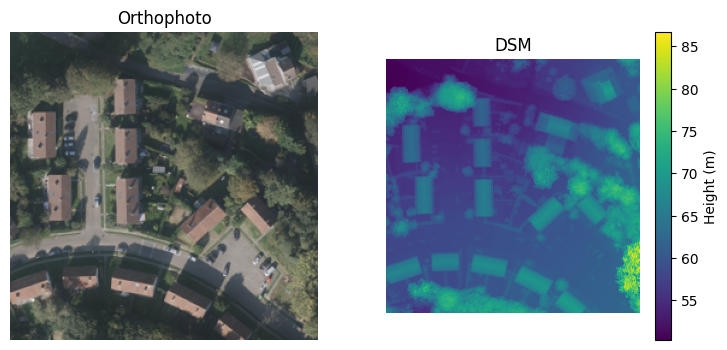

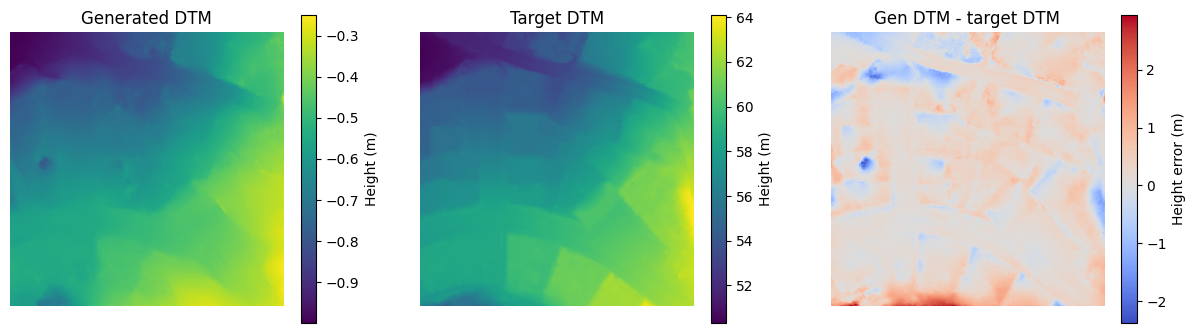

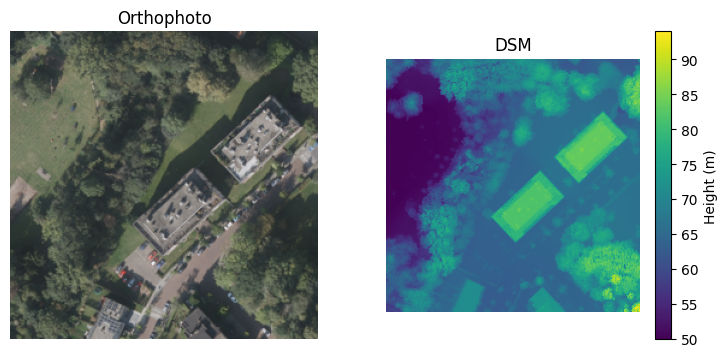

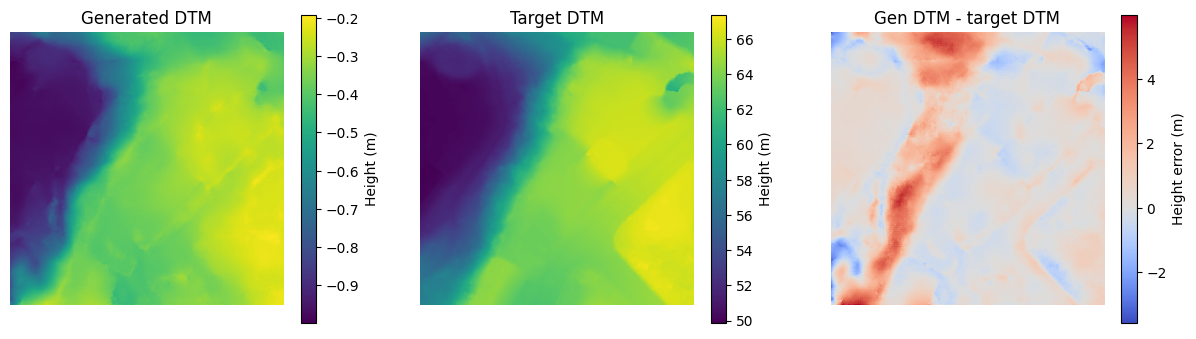

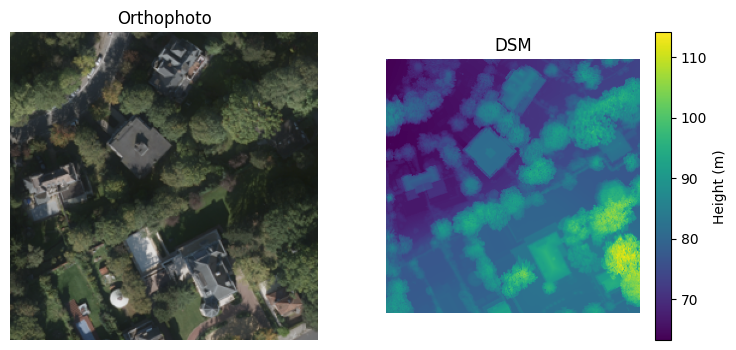

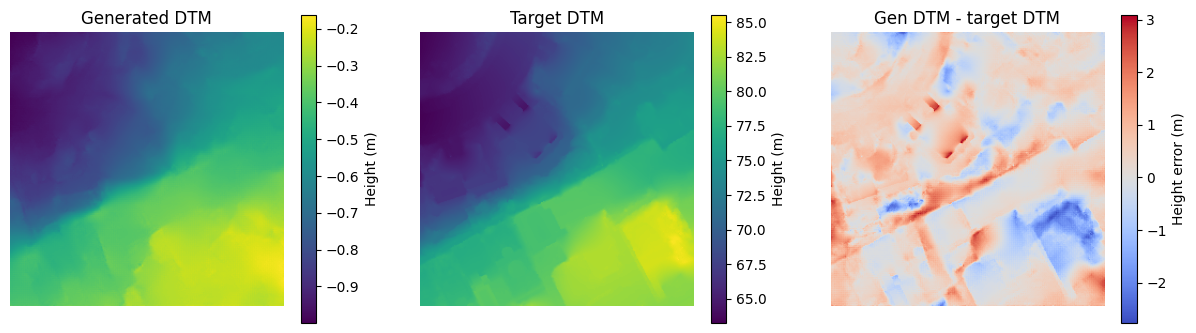

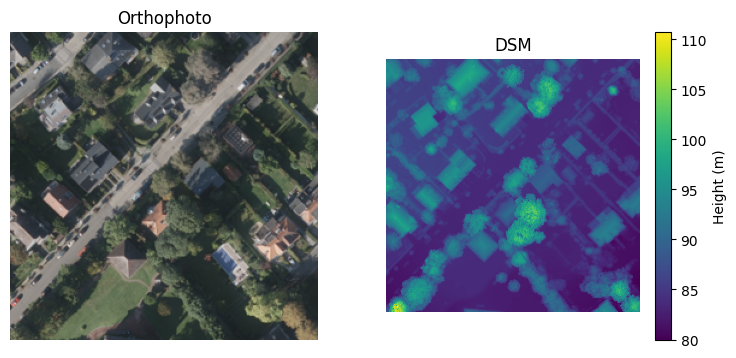

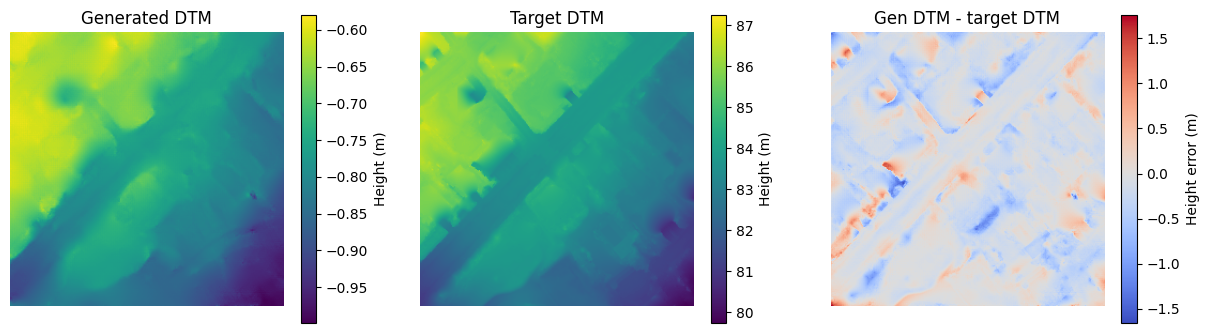

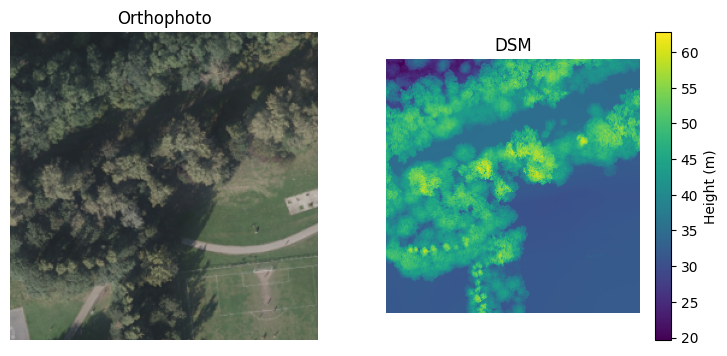

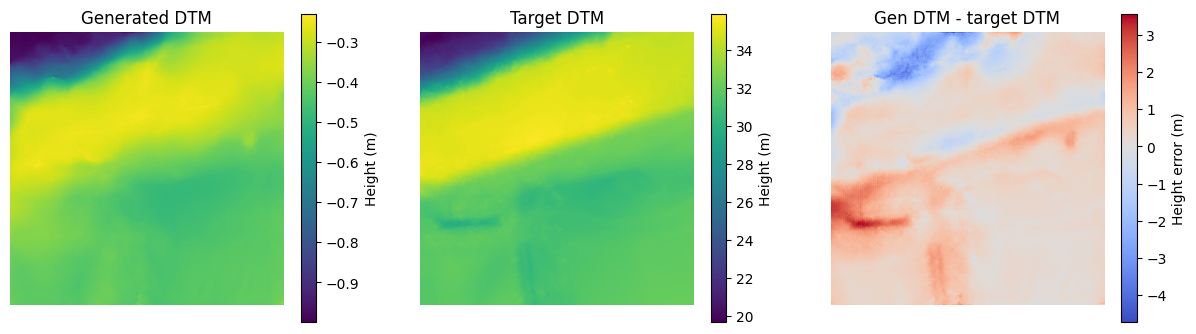

In [31]:
path = 'Figures/Gan stats images/sem_map/dtms/'
for i in range(5):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(9)
    ax = axs[0]
    ax.title.set_text('Orthophoto')
    im = ax.imshow(ex_images[i])
    ax.axis('off')
    ax = axs[1]
    ax.title.set_text('DSM')
    im = ax.imshow(ex_dsms[i])
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height (m)')
    ax.axis('off')
    #plt.savefig(path + 'dsm_' + str(i))


    fig, axs = plt.subplots(1,3)
    fig.set_figheight(4)
    fig.set_figwidth(15)
    ax = axs[0]
    ax.title.set_text('Generated DTM')
    im = ax.imshow(ex_preds[i])
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height (m)')
    ax = axs[1]
    ax.title.set_text('Target DTM')
    im = ax.imshow(ex_dtms[i])
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height (m)')
    ax.axis('off')
    ax = axs[2]
    ax.title.set_text('Gen DTM - target DTM')
    im = ax.imshow(ex_err[i], cmap=shift_cmap_midpoint(ex_err[i], i))
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height error (m)')
    ax.axis('off')
    #plt.savefig(path + 'dtm_' + str(i))

In [32]:
def plot_hist(err_ds, hist_range, title, use_class=False, coef=100):
    # computes and plots the distribution of the errors in the predicted heights
    # the 'coef' parameter is just used for the second histogram, to have all the percentages add up to 'coef', which should be the percentage of errors lower than 1m
    if hist_range == 1:
        bins = [0.0,1.0,2.0,100.0]
        ticks = ['<1m', '[1m-2m]', '>2m']
    elif hist_range == 2:
        bins = [0.0,0.2,0.4,0.6,0.8,1]
        ticks = ['0-0.2m','0.2-0.4m','0.4-0.6m','0.6-0.8m','0.8-1m']

    hist_tot = np.zeros(len(bins)-1)
    
    if not use_class:
        for i in err_ds.map(lambda x: tf.reshape(x, [x.shape[0]*x.shape[1]])).as_numpy_iterator():
            hist = np.histogram(i, bins=bins)
            hist_tot += hist[0]
    else:
        for i in err_ds.map(lambda x, y: (tf.reshape(x, [x.shape[0]*x.shape[1]]), tf.reshape(y, [y.shape[0]*y.shape[1]]))).as_numpy_iterator():
            selected_err = i[0][np.nonzero(i[1])]
            hist = np.histogram(selected_err, bins=bins)
            hist_tot += hist[0]
        
            
    hist_tot = coef*hist_tot/np.sum(hist_tot)
    
    bar = plt.bar(list(range(len(bins) - 1)), hist_tot, width=0.7, tick_label=ticks)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}' + '%', ha='center', va='bottom')
        plt.title(title)

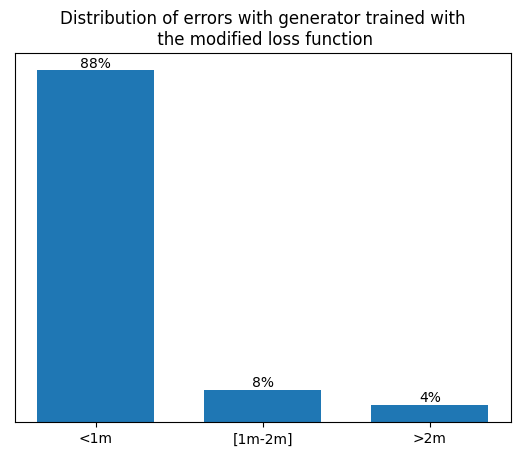

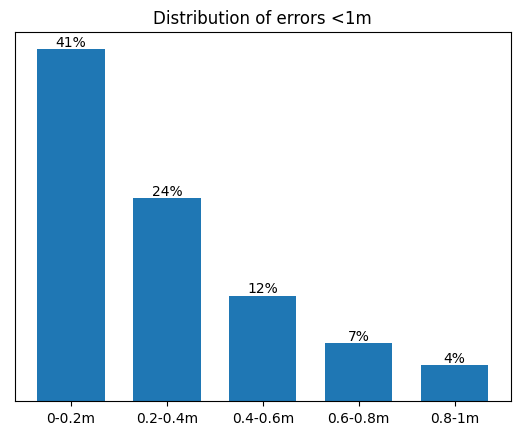

In [33]:
plot_hist(error_locs_ds, 1, 'Distribution of errors with generator trained with\n the modified loss function')
#plt.savefig('sem_map_err_barplot.png')
plt.figure()
plot_hist(error_locs_ds, 2, 'Distribution of errors <1m', coef=88)
#plt.savefig('sem_map_err_barplot2.png')

In [34]:
obj_mask = raw_test_dataset256.map(lambda x,y: tf.cast(tf.math.greater (x[:,:,0]-y, tf.constant(0.01)), dtype='float32'))
ground_mask = raw_test_dataset256.map(lambda x,y: tf.cast(tf.math.greater (y-x[:,:,0], tf.constant(-0.01)), dtype='float32'))

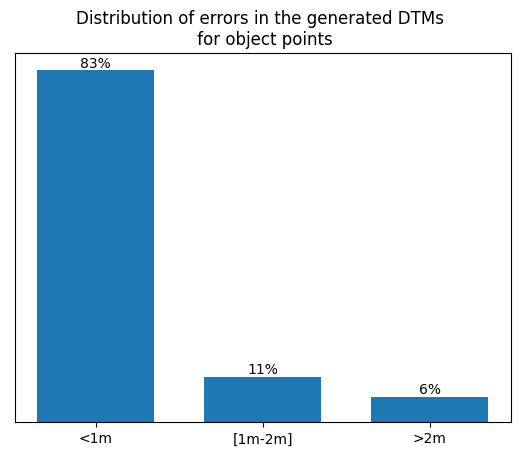

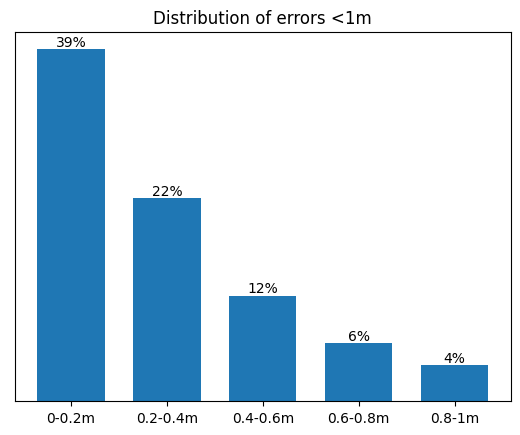

In [35]:
obj_err = tf.data.Dataset.zip((error_locs_ds, obj_mask))
n = 0
plot_hist(obj_err, 1, 'Distribution of errors in the generated DTMs \n for object points', use_class=True)
plt.savefig('sem_map_err_op.png')
plt.figure()
plot_hist(error_locs_ds, 2, 'Distribution of errors <1m', coef=83)
plt.savefig('sem_map_err_op2.png')

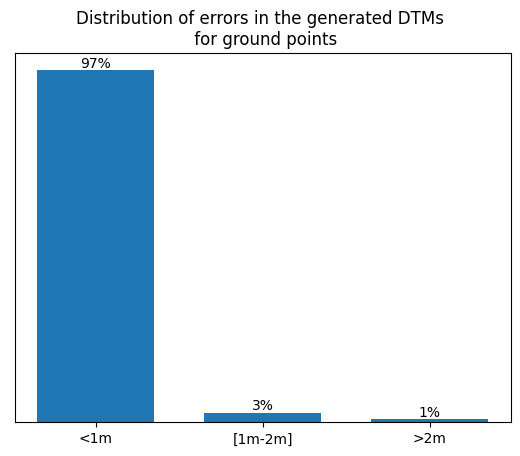

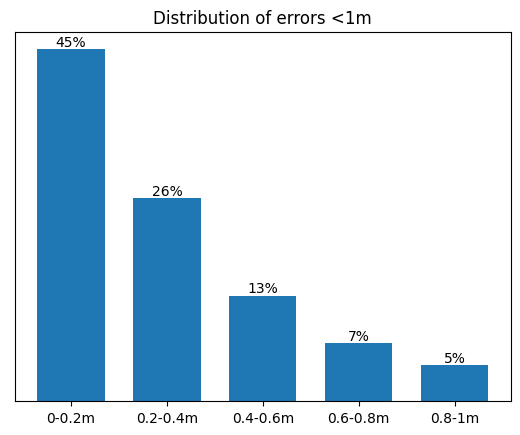

In [36]:
ground_err = tf.data.Dataset.zip((error_locs_ds, ground_mask))
n = 0
plot_hist(ground_err, 1, 'Distribution of errors in the generated DTMs \n for ground points', use_class=True)
plt.savefig('sem_map_err_gp.png')
plt.figure()
plot_hist(error_locs_ds, 2, 'Distribution of errors <1m', coef=96)
plt.savefig('sem_map_err_gp2.png')

## Results with validation dataset

In [38]:
val_dataset512 = pp.make_tf_dataset(512, 'val', True)
norm_val_ds512 = pp.normalize_tf_dataset(val_dataset512, rgb=True)

In [39]:
val_masks = segmentor.predict(norm_val_ds512.batch(1), verbose=0)

In [40]:
val_masks.shape

(129, 512, 512, 1)

In [41]:
val_masks = (val_masks>=0.5).astype('int32')
val_masks256 = np.array(list(map(divide_one_array,val_masks))).reshape(516,256,256,1)
val_masks_ds = tf.data.Dataset.from_generator(mask_ds_gen, args=(2,), output_signature=(tf.TensorSpec(shape=(256,256,1), dtype=tf.float32)))

val_input = val_dataset512.map(lambda x,y:tf.reshape(x[:,:,0], [512,512,1]))

val_dtm = val_dataset512.map(lambda x,y:y)
    
val_input = val_input.map(lambda x: divide_tensor(x))
val_dtm = val_dtm.map(lambda x: divide_tensor(x))

val_input = val_input.flat_map(tf.data.Dataset.from_tensor_slices)
val_dtm = val_dtm.flat_map(tf.data.Dataset.from_tensor_slices)

raw_val_dataset256 = tf.data.Dataset.zip((val_input,val_dtm)).map(lambda x,y: (x, tf.reshape(y,[256,256])))
val_dataset256 = pp.normalize_tf_dataset(raw_val_dataset256, False)

val_dataset256 = tf.data.Dataset.zip((val_dataset256, val_masks_ds))
val_dataset256 = val_dataset256.map(lambda x,y: (tf.concat((x[0],y),axis=-1), x[1]))

In [42]:
gen = mod.Generator256(2,256)
checkpoint = tf.train.Checkpoint(generator=gen)
checkpoint.restore('training_checkpoints/gan_sem_map/ckpt-1').expect_partial()
preds = gen.predict(val_dataset256.batch(1))

516/516 [==============================] - 9s 15ms/step


In [43]:
tbs = [] #list containing the value of highest and lowest pixel in each DSM (for normalization)
res = preds[0].shape[1] #256 or 512
test_ds = raw_val_dataset256.map(lambda x,y: (tf.expand_dims(x[:,:,0], axis=-1), y))
tbs_ds = test_ds.map(lambda x, y : (tf.math.reduce_max(x[:,:,0]), tf.math.reduce_min(x[:,:,0])))

for i in tbs_ds.as_numpy_iterator(): #fill the tbs list
    tbs.append(i)

dtms = test_ds.map(lambda x, y: y)
ssum = 0
ssum_L1 = 0
n = res**2

N = str(preds.shape[0])
i = 0
for j in dtms.as_numpy_iterator():
    pred = preds[i]
    pred = pp.denormalize(pred, tbs[i][0], tbs[i][1])
    dif = np.sum((pred[:,:,0] - j)**2)
    dif_L1 = np.sum(tf.abs((pred[:,:,0] - j)))
    ssum += dif
    ssum_L1 += dif_L1
    i += 1
    #print(str(i) + '/' + N, end='\r')
#print(i)
print(np.sqrt(ssum/(i*n)))
print(ssum_L1/(i*n))

1.0383453599891384
0.4986839902608894
